# TTT for VarNet under an acceleration shift

**Overview.** This notebook provides the code to apply TTT to VarNet when it's tested under an acceleration distribution shift from the 4x to the 2x accelerated MRI reconstruction task.

The experiment uses the following VarNet models:

knee\_sup: This is a VarNet trained on 300 4x-accelerated knee PD middle slices of the fastMRI training set, in a supervised manner.<br>
knee\_self: This is a VarNet trained on 300 4x-accelerated knee PD middle slices of the fastMRI training set, when self-supervision is included during training.<br>
2x\_sup: This is a VarNet trained on 300 2x-accelerated knee PD middle slices of the fastMRI training set, in a supervised manner.<br>
2x\_self: This is a VarNet trained on 300 2x-accelerated knee PD middle slices of the fastMRI training set, when self-supervision is included during training.

We apply test-time training (TTT) to the four models above to demonstrate that TTT is only effective when self-supervision is included. The self-supervised loss on which we perform TTT (and is part of the training loss) is as follows:

$$
L(\theta) = \frac{\|Y - ASf_\theta(A^\dagger Y)\|_1}{\|Y\|_1}.
$$
Here, $A = MF$ where $M$ is the under-sampling mask and $F$ is the discrete Fourier transform. Moreover, $S$ is the estimated coil sensitivity maps obtained from espirit. 
We optimize this loss function via adam optimizer.

In [1]:
import functions.utils as utils 
from functions.helpers import *
from functions.common.subsample import RandomMaskFunc, EquispacedMaskFunc 
from functions.include import * 
from functions.common.evaluate import * 
from functions.varnet import VariationalNetworkModel
from functions.include import transforms as transform 

import matplotlib.pyplot as plt
import glob 
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import torch
import h5py
import time
import copy

import warnings
warnings.filterwarnings('ignore')

### after you install bart 0.6.00 from https://mrirecon.github.io/bart/, import it as follows
sys.path.insert(0,'/root/bart-0.6.00/python/')
os.environ['TOOLBOX_PATH'] = "/root/bart-0.6.00/"
import bart
###

from torch.autograd import Variable
from skimage.measure import compare_ssim

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("num GPUs",torch.cuda.device_count())

num GPUs 1


## Evaluation functions

In [2]:
def normalize(im1,im2):
    # im1: ground truth
    # im2: reconstruction
    im2 = (im2-im2.mean()) / im2.std()
    im2 *= im1.std()
    im2 += im1.mean()
    return im1,im2
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

In [3]:
def rss_ksp(slice_tt):
    ### this function computes the ifft of root sum of squares of under-sampled k-space images
    slicei_tt = transform.root_sum_of_squares(ifft2(slice_tt))[None,:]
    slice_tt_rss = fft2(slicei_tt).type(dtype)
    return slice_tt_rss
def evaluate(mdl, slice_tt_scale, orig, sens_map, mask,):
    slice_tt_rss = rss_ksp(slice_tt_scale)
    with torch.no_grad():
        output,ksp = mdl(slice_tt_rss[None,:].type(dtype) ,mask.type(torch.cuda.ByteTensor), sens_map[None,:])
    
    crop = orig.shape
    rec = center_crop( complex_abs(output[0,0]).data.cpu().numpy(), crop )
    
    im1,im2 = normalize(orig,rec)
    score = ssim(np.array([im1]),np.array([im2]))
    
    return orig, rec, score

## Create a VarNet model

In [4]:
### Hyper-parameters
class args():
    def __init__(self):
        self.pools = 4
        self.chans = 18
        self.sens_chans = 8
        self.sens_pools = 4
        self.num_cascades = 12
Args = args()

### create the model
net = VariationalNetworkModel(Args)
net.cuda();

ctr = 0
for p in net.parameters():
    ctr += len(p.flatten())
    
print('#params:',ctr)

#params: 29452068


## Load checkpoints

### trained on knee images in a supervised manner (4x acceleration)

In [5]:
knee_sup = copy.deepcopy(net)

In [6]:
checkpoint = torch.load('./varnet_model_checkpoints/knee_supervised.pt', map_location='cpu')
knee_sup.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### trained on knee images with a joint loss incorporating self-supervision (4x acceleration)

In [7]:
knee_self = copy.deepcopy(net)

In [8]:
checkpoint = torch.load('./varnet_model_checkpoints/knee_with_self_supervision.pt', map_location='cpu')
knee_self.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### trained on knee images in a supervised manner (2x acceleration)

In [10]:
x2_sup = copy.deepcopy(net)

In [12]:
checkpoint = torch.load('./varnet_model_checkpoints/2x_supervised.pt', map_location='cpu')
x2_sup.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### trained on knee images with a joint loss incorporating self-supervision (2x acceleration)

In [13]:
x2_self = copy.deepcopy(net)

In [14]:
checkpoint = torch.load('./varnet_model_checkpoints/2x_with_self_supervision.pt', map_location='cpu')
x2_self.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Scaling function
The sensitivity maps are scaled (for U-Net, the under-sampled $k$-space was scaled) such that the norm of output image is close to the norm of the input image. 

In [15]:
def scale_factor(slice, sens, net, mask,mask2d):
    slice_tt = transform.to_tensor(slice)
    slice_tt_rss = rss_ksp(slice_tt)
    
    scale = 1
    S = transform.to_tensor(sens*scale)

    ## forward pass
    with torch.no_grad():
        output,ksp = net(slice_tt_rss[None,:], mask.type(torch.cuda.ByteTensor), S[None,:].type(dtype))

    ## apply forward model A = Mask * Fourier * Sensitivity_map
    # apply sensitivity map
    imgs = torch.zeros(S.shape).type(dtype) 
    for j,s in enumerate(S.type(dtype)):
        ss = s.clone()
        ss[torch.abs(ss)==0.0] = torch.abs(ss).max()
        imgs[j,:,:,0] = output[0,0,:,:,0] * ss[:,:,0] - output[0,0,:,:,1] * ss[:,:,1]
        imgs[j,:,:,1] = output[0,0,:,:,0] * ss[:,:,1] + output[0,0,:,:,1] * ss[:,:,0]
    # apply the Fourier transform
    Fimg = fft2(imgs)
    # apply the under-sampling mask
    maskk = torch.from_numpy( np.tile(mask2d[None,:,:,None],(slice_tt.shape[0],1,1,2)) ).type(dtype)
    Fimg_forward = Fimg * maskk

    ## compute the scaling factor
    inp = torch.norm(complex_abs(ifft2(slice_tt_rss.data.cpu())))
    out = torch.norm(rss_torch(complex_abs(ifft2(Fimg_forward)).data.cpu()))
    scale *= (torch.norm(inp) / torch.norm(out)).numpy()[np.newaxis][0]
    
    return scale

## Define the test file name and load the under-sampling mask

In [16]:
filename = './test_data/acceleration_shift/file1000126.h5' ### load this filename (or any other PD file) from the fastMRI knee validation set that matches the mask resolution

with open('./test_data/acceleration_shift/mask2x','rb') as fn:
    original_mask = pickle.load(fn)

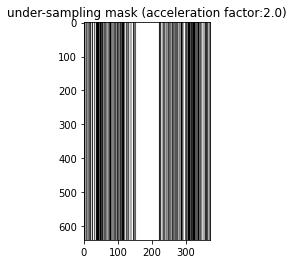

In [17]:
plt.imshow(original_mask,'gray')
plt.title('under-sampling mask (acceleration factor:{})'.format(np.round(original_mask.shape[1]/np.sum(original_mask[0]),2)))
plt.show()

## Inference with/without test-time training

### Normalized $\ell_1$ loss function

In [18]:
class Loss(torch.nn.Module):
    def __init__(self):
        super(Loss,self).__init__()

    def forward(self,x,y):
        loss = torch.norm(y - x,1) / torch.norm(x.detach(),1)
        return loss

### The inference module
This will do inference with or without test-time trainnig. For evaluation, the ``evaluate`` function above is called.

In [19]:
def inference(model, filename, mask2d):

    tic = time.time()

    ### load the k-space and prepare network input
    f = h5py.File(filename, 'r')
    
    # take the middle slice
    sh = f["kspace"].shape
    slice_ksp = f['kspace'][sh[0]//2] # middle slice k-space
    origk = f['reconstruction_rss'][sh[0]//2] # ground truth
    masked_ksp = slice_ksp * np.tile(mask2d[None,...],(slice_ksp.shape[0],1,1)) # under-sample the k-space
    slice = np.stack((masked_ksp.real, masked_ksp.imag), axis=-1) # separate real-imag parts for pytorch
    slice_tt = torch.from_numpy(slice).type(dtype) # create the pytorch-formatted under-sampled k-space
    slice_tt_rss = rss_ksp(slice_tt) # ifft2 of root sum of squares of under-sampled coil images
    
    ##### sensitivity map estimation
    zpad = slice_tt.data.cpu().numpy()
    zpad_complex = []
    for i in range(zpad.shape[0]):
        zpad_complex += [zpad[i,:,:,0]+1j*zpad[i,:,:,1]]
    zpad_complex = np.array(zpad_complex)
    masked_complex_kspace = zpad_complex * np.array(slice_tt.shape[0]*[list(mask2d)]) 
    sens_maps = bart.bart(1, f'ecalib -d0 -m1', np.array([np.moveaxis(masked_complex_kspace,0,2)]))
    sens_map = np.moveaxis(sens_maps[0],2,0)
    
    ### compute the scaling factor to match the norms of input and output
    mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) )
    scale = scale_factor(masked_ksp, sens_map, model, mask,mask2d)
    S = transform.to_tensor(sens_map*scale).type(dtype)
    
    ############################### inference without test-time training
    _, rec, score = evaluate(model,slice_tt,origk,sens_map*scale, mask,)
    
    ############################### inference with test-time training
    ### mask partitioning for self validation: we define a left-out set for early-stopping
    where_ones = np.array(np.where(mask2d==1))
    m = len( where_ones[0] ) 
    self_val_ids = where_ones[:,np.random.randint(0,m,m//20)] # set 5% of the pixels to zero (leave-outs for self validation)
    mask2dttt = mask2d.copy()
    mask2dttt[self_val_ids[0],self_val_ids[1]] = 0
    ###
    
    slice_tt_scale = slice_tt.clone()
    scores = []   # this monitors SSIM w.r.t. the ground truth (in practice we don't have the ground truth, here we just use it to plot how accuracy changes based on epoch number)
    errors = []  # this monitors test-time training loss (which is a self-supervised loss)
    verrors = [] # this monitors the self-validation error at each epoch
    import copy
    model_ttt = copy.deepcopy(model)

    p = [param for param in model_ttt.parameters()]
    optimizer = torch.optim.Adam(p, lr=1e-4)
    l1loss = Loss()
    num_epochs = 2500 # number of TTT iterations
    window_size = 100 # this denotes a sliding window to monitor the average self-validation error 
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        ### make a forward pass
        output,ksp = model_ttt(slice_tt_rss[None,:], mask.type(torch.cuda.ByteTensor), S[None,:].type(dtype))
        
        ### apply the sensitivity maps
        imgs = torch.zeros(S.shape).type(dtype) 
        for j,s in enumerate(S):
            ss = s.clone()
            ss[torch.abs(ss)==0.0] = torch.abs(ss).max()
            imgs[j,:,:,0] = output[0,0,:,:,0] * ss[:,:,0] - output[0,0,:,:,1] * ss[:,:,1]
            imgs[j,:,:,1] = output[0,0,:,:,0] * ss[:,:,1] + output[0,0,:,:,1] * ss[:,:,0]
        Fimg = fft2(imgs)
        
        ### apply the forward model
        maskk = torch.from_numpy( np.tile(mask2d[None,:,:,None],(slice_tt_scale.shape[0],1,1,2)) ).type(dtype)
        Fimg_forward = Fimg * maskk.type(dtype)

        ### separate self-validation and test-time training measurements
        Fimg_forward_train = Fimg_forward.clone()
        Fimg_forward_train[:,self_val_ids[0],self_val_ids[1],:] = 0
        slice_tt_scale_train = slice_tt_scale.clone()
        slice_tt_scale_train[:,self_val_ids[0],self_val_ids[1],:] = 0
        
        ### compute the loss
        loss = l1loss(slice_tt_scale_train.type(dtype),Fimg_forward_train)
        error = loss.data.cpu().numpy()
        
        ### compute the self-validation error
        verror = l1loss(slice_tt_scale.type(dtype)[:,self_val_ids[0],self_val_ids[1],:],Fimg_forward[:,self_val_ids[0],self_val_ids[1],:]).data.cpu().numpy()
        
        ### do the backward pass
        loss.backward()
        optimizer.step()

        _, rec_ttt, score_ttt = evaluate(model_ttt,slice_tt,origk,sens_map*scale, mask,)
        if epoch > 3*window_size:
            if np.mean(verrors[-window_size:]) > np.mean(verrors[-2*window_size:-window_size]): 
                print('\nAutomatic early stopping activated.')
                break
        scores.append(score_ttt)
        errors.append(error)
        verrors.append(verror)
        
        print('TTT... epoch {}/{}... loss {}... time {} mins'.format(epoch+1,num_epochs,np.round(error,6), np.round( (time.time()-tic)/60,1 )),'\r',end='')
    ######################################################################### 

    f.close()
    
    ''' Here, we display how the training and self-validation errors, in addition to SSIM w.r.t. 
    the ground-truth image behave during test-time training iterations.'''
    print('\ninference logs:')
    
    fig = plt.figure(figsize=(15,3))

    ax = fig.add_subplot(131)
    ax.plot(scores)
    ax.set_title('SSIM w.r.t. GT')

    ax = fig.add_subplot(132)
    ax.plot(errors)
    ax.set_title('l1 w.r.t. y_train')

    ax = fig.add_subplot(133)
    ax.plot(verrors)
    ax.set_title('l1 w.r.t. y-self-val')

    plt.show()
    
    return rec, score, rec_ttt, score_ttt, origk

## We now apply test-time training to all 4 models loaded above

********** knee_sup **********
TTT... epoch 325/2500... loss 0.742510974407196... time 3.6 mins  
Automatic early stopping activated.

inference logs:


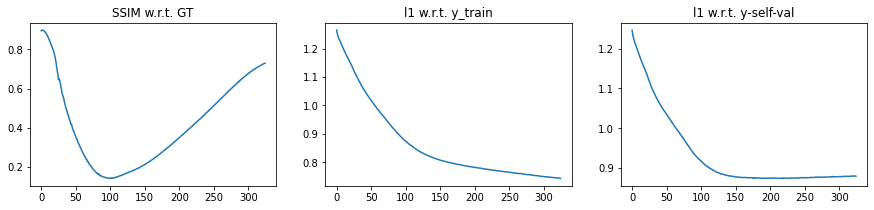

********** knee_self **********
TTT... epoch 301/2500... loss 0.7581639885902405... time 3.3 mins 
Automatic early stopping activated.

inference logs:


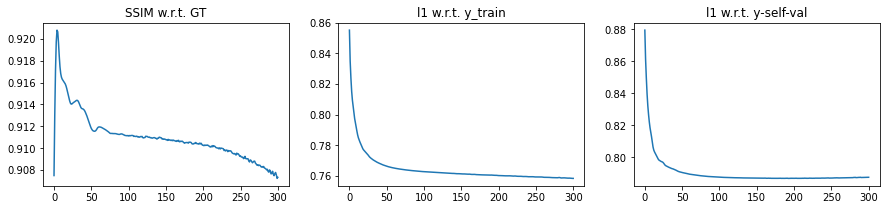

********** 2x_sup **********
TTT... epoch 816/2500... loss 0.7117919921875... time 8.4 mins ns 
Automatic early stopping activated.

inference logs:


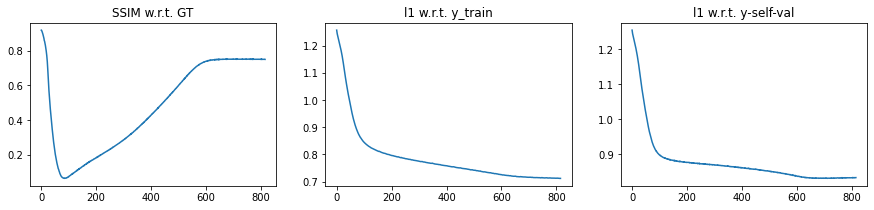

********** 2x_self **********
TTT... epoch 394/2500... loss 0.7598140239715576... time 4.1 mins 
Automatic early stopping activated.

inference logs:


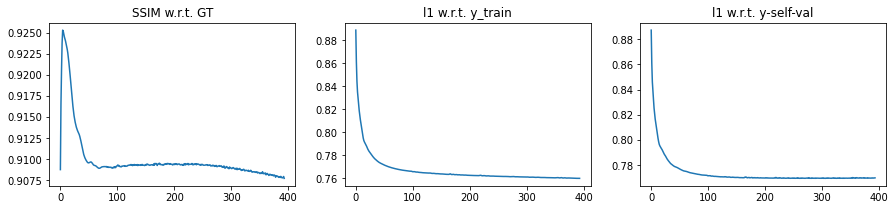

In [20]:
model_names = ['knee_sup','knee_self','2x_sup','2x_self']

results = dict([(name,{}) for name in model_names]) 
results_ttt = dict([(name,{}) for name in model_names])
for model,model_name in zip([knee_sup, knee_self, x2_sup, x2_self],model_names):
    print('*'*10,model_name,'*'*10)
    rec, score, rec_ttt, score_ttt, orig = inference(model, filename, original_mask)
    results[model_name]['ground truth'] = orig
    results[model_name]['reconstruction'] = rec
    results[model_name]['ssim'] = score
    
    results_ttt[model_name]['ground truth'] = orig
    results_ttt[model_name]['reconstruction'] = rec_ttt
    results_ttt[model_name]['ssim'] = score_ttt

## Visualization

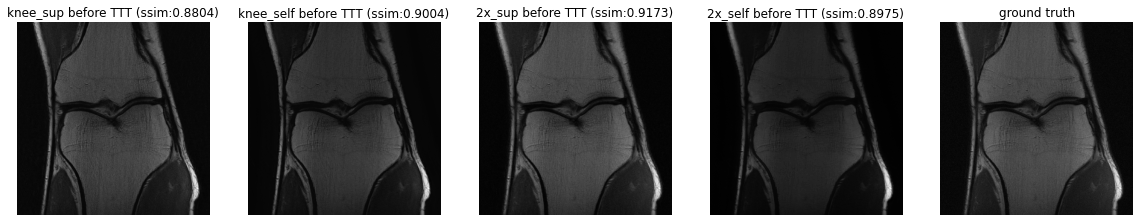

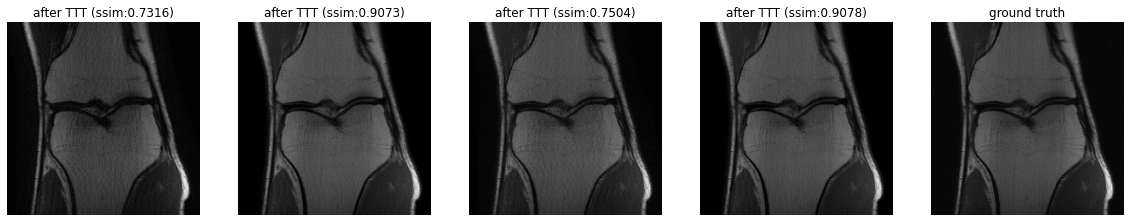

In [21]:
### before TTT
fig = plt.figure(figsize=(20,14))
for i,model_name in enumerate(model_names):
    ax = fig.add_subplot(1,5,i+1)
    ax.imshow(results[model_name]['reconstruction'],'gray')
    ax.axis('off')
    ax.set_title(model_name+' before TTT '+'(ssim:{})'.format(np.round(results[model_name]['ssim'],4)))
    
    if i == len(model_names)-1:
        ax = fig.add_subplot(1,5,i+2)
        ax.imshow(results[model_name]['ground truth'],'gray')
        ax.axis('off')
        ax.set_title('ground truth')
plt.show()

### after TTT
fig = plt.figure(figsize=(20,14))
for i,model_name in enumerate(model_names):
    ax = fig.add_subplot(1,5,i+1)
    ax.imshow(results_ttt[model_name]['reconstruction'],'gray')
    ax.axis('off')
    ax.set_title('after TTT '+'(ssim:{})'.format(np.round(results_ttt[model_name]['ssim'],4)))
    
    if i == len(model_names)-1:
        ax = fig.add_subplot(1,5,i+2)
        ax.imshow(results_ttt[model_name]['ground truth'],'gray')
        ax.axis('off')
        ax.set_title('ground truth')
plt.show()

**Remarks:**

As pointed out in our paper:

    - Comparing ``2x_self+TTT'' and ``knee_self+TTT'' with ``2x_sup'' and ``knee_sup'' demonstrates the closure of the distribution shift performance gap.
    
    - Applying TTT to ``knee_sup'' yields an SSIM score of 0.7316 which suggests that self-supervision is needed during training so that TTT closes the robustness gap.
    
    - When self-supervision is included in training, in- and out-of-distribution performance is degraded. However, this drop is compensated with TTT.